In [24]:
import datetime as dt
import pandas as pd
import numpy as np
import calendar

# from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

In [25]:
end = dt.datetime.now()
start = dt.datetime(2000,1,1)

# df = pdr.get_data_yahoo(['^AXJO'], start, end)
df = yf.download(['^AXJO'], start, end)
Close = df.Close
Close.head()

[*********************100%***********************]  1 of 1 completed


Date
2000-01-04    3093.699951
2000-01-05    3018.699951
2000-01-06    2999.300049
2000-01-07    3023.399902
2000-01-10    3084.000000
Name: Close, dtype: float64

<Axes: xlabel='Date'>

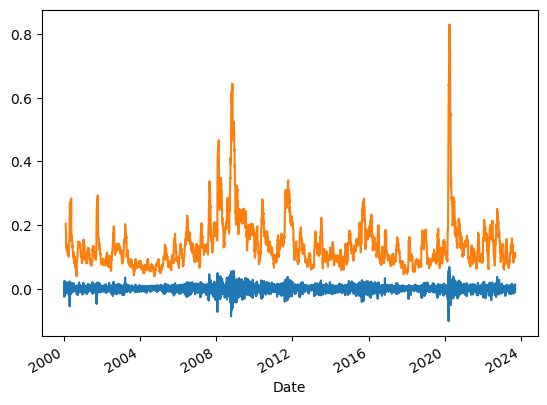

In [26]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns.plot()

TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility.plot()

# Creating Historical Volatility Cones

In [27]:
def ThirdThurs(year, month):
    # Create a datetime.date for the last day of the given month
    daysInMonth = calendar.monthrange(year, month)[1]   # Returns (month, numberOfDaysInMonth)
    date = dt.date(year, month, daysInMonth)
    # Back up to the most recent Thursday
    offset = 4 - date.isoweekday()
    if offset > 0: 
        offset -= 7                          # Back up one week if necessary
    date += dt.timedelta(offset)                    # dt is now date of last Th in month
    
    # Throw an exception if dt is in the current month and occurred before today
    now = dt.date.today()                         # Get current date (local time, not utc)
    if date.year == now.year and date.month == now.month and date < now:
        raise Exception('Missed third thursday')

    return date - dt.timedelta(7)

dates = [ThirdThurs(year, month) for year in range(2000,2022) for month in range(1,13) if ThirdThurs(year, month) < dt.datetime.now().date()]
columnsNames = ['1-mth','3-mth', '6-mth', '9-mth', '12-mth']
tradingDays = [int(20*n) for n in [1,3,6,9,12]]
DTE = [int(30*n) for n in [1,3,6,9,12]]
data = np.array([np.arange(len(dates))]*len(columnsNames)).T

tradingDays
volatility = {}
for TRADING_DAYS, TimePeriod in zip(tradingDays, columnsNames):
    print(TRADING_DAYS, TimePeriod)
    volatility[TimePeriod] = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

20 1-mth
60 3-mth
120 6-mth
180 9-mth
240 12-mth


Once we’ve done that we can build up our historical cone dataframe.

In [32]:
df = pd.DataFrame(data, columns=columnsNames, index=dates)
df.index.name = 'period'
def historical_vol(x):
    df2 = x.copy()
    for date, val in x.items():
        try:
            df2.loc[date] = round(volatility[x.name].loc[date,'^AXJO']*100,2)
        except:
            df2.loc[date] = np.nan
    return df2
df = df.apply(lambda x: historical_vol(x),axis=0)

In [37]:
df2 = pd.DataFrame(data='', columns=['max','mean','min'], index=DTE)
df2.index.name = 'DTE'

df2['max'] = pd.Series(df[columnsNames].max().values, index=DTE)
df2['mean'] = pd.Series(df[columnsNames].mean().values, index=DTE)
df2['min'] = pd.Series(df[columnsNames].min().values, index=DTE)

Plotting basic cone with matplotlib.

(0.0, 370.0)

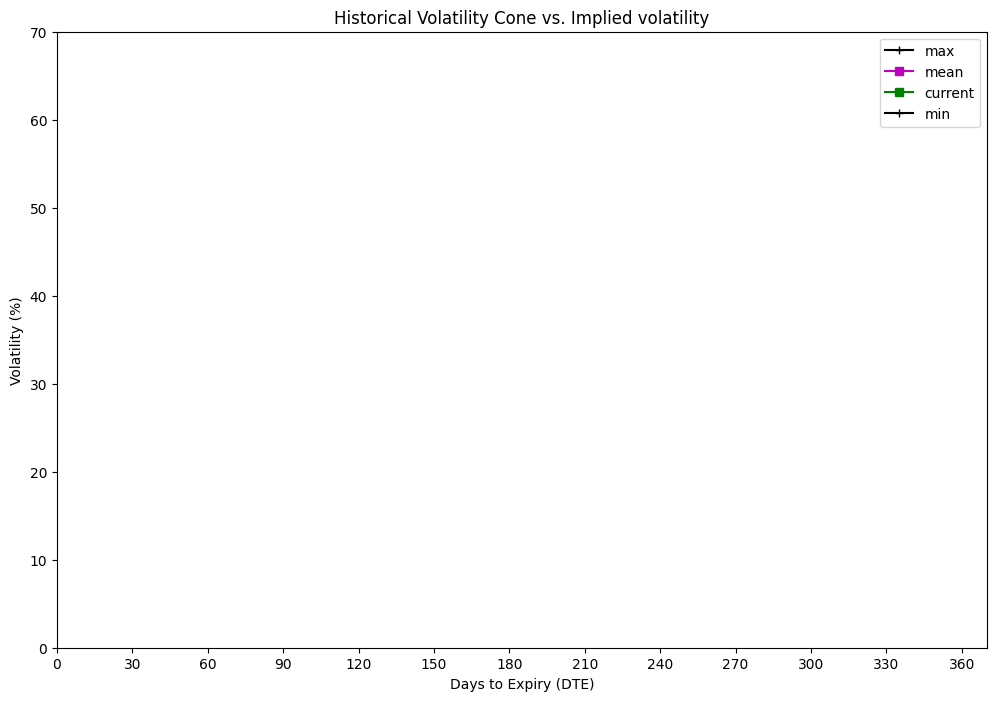

In [41]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(111)
plt.plot(df2.index, df2['max'], 'k+-')
plt.plot(df2.index, df2['mean'], 'ms-')
plt.plot(df2.index, df.iloc[-1,:], 'gs-')
plt.plot(df2.index, df2['min'], 'k+-')
for i, v in df2['mean'].items():
    if not math.isnan(v):
        ax1.text(i, v+1, "%d" %v, ha="center")
for i, v in enumerate(df.iloc[-1,:]):
    if not math.isnan(v):
        ax1.text(df2.index[i], v-2.5, "%d" %v, ha="center")

plt.title('Historical Volatility Cone vs. Implied volatility')
plt.legend(['max', 'mean', 'current','min' ], loc='upper right')
plt.xlabel('Days to Expiry (DTE)')
plt.ylabel('Volatility (%)')
plt.xticks(np.linspace(0,360,13))
plt.ylim(0, 70)
plt.xlim(0, 370)

# Adding Implied Volatility

In [18]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.3 #initial guess 

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) &lt; tol or abs(new_bs_price-market_price) &lt; tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

SyntaxError: invalid syntax (1622627823.py, line 23)

In [19]:
S0 = 7375

atm_options = [
[dt.date(2021,8,19),7375,[0.88,0.98],[1.09,1.2]],
[dt.date(2021,9,16),7375,[1.06,1.16],[1.91,2.06]],
[dt.date(2021,10,21),7375,[1.54,1.67],[2.42,2.58]],
[dt.date(2021,11,18),7375,[1.76,1.94],[2.82,3.17]],
[dt.date(2021,12,16),7250,[2.7,2.95],[2.6,2.85]],
[dt.date(2022,3,17),6000,[12.13,12.9],[0.87,0.98]]
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date.today()).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3] 
    
    call_bids.append(implied_vol(S0, K, T, r, call_bid*100, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask*100, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid*100, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask*100, flag='p')*100)
    IV_DTE.append(DTE)

NameError: name 'implied_vol' is not defined

AttributeError: 'Series' object has no attribute 'iteritems'

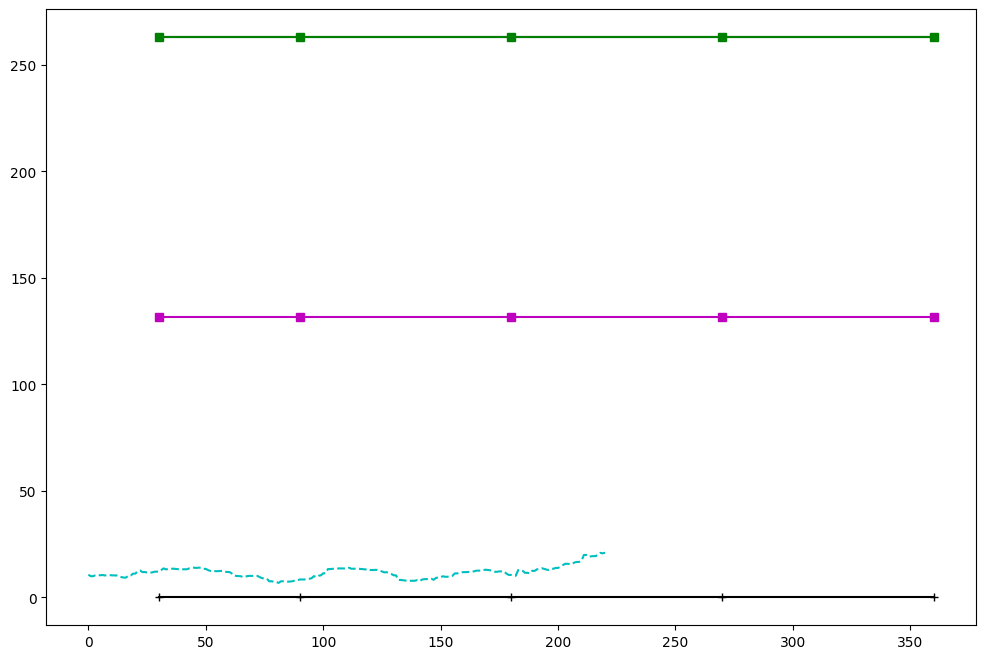

In [20]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(111)

plt.plot(df2.index, df2['max'], 'k+-')
plt.plot(df2.index, df2['mean'], 'ms-')

plt.plot(df2.index, df.iloc[-1,:], 'gs-')

plt.plot(IV_DTE, call_asks, 'bo--')
plt.plot(IV_DTE, call_bids, 'ro--')

plt.plot(IV_DTE, put_asks, 'bs-')
plt.plot(IV_DTE, put_bids, 'rs-')

HV_30d = log_returns.rolling(window=30).std()*np.sqrt(252)
plt.plot(range(0,221), HV_30d.values[-221:][::-1]*100, 'c--')
plt.plot(df2.index, df2['min'], 'k+-')

for i, v in df2['mean'].iteritems():
    ax1.text(i, v+1, "%d" %v, ha="center")
for i, v in enumerate(df.iloc[-1,:]):
    ax1.text(df2.index[i], v-2.5, "%d" %v, ha="center")

plt.title('Historical Volatility Cone vs. Implied volatility')
plt.legend(['max', 'mean', 'current', 'Call Ask IV','Call Bid IV', 'Put Ask IV','Put Bid IV',
            '30-day HV', 
            'min' ], loc='upper right')

plt.xlabel('Days to Expiry (DTE)')
plt.ylabel('Volatility (%)')
plt.xticks(np.linspace(0,360,13))
plt.ylim(0, 70)
plt.xlim(0, 370)